# 手順

## データ加工
 - テスト：3031 非テスト3032以降
 - node_listを配列に戻す
 - landing_pageをusefulだけにする
 - 2ページ目の遷移ページとcv_idの2カラムのデータを作る

## 分析方法

### LPのクラスター×2ページ目以降閲覧クラスター×CVを見て、傾向を把握
　- 傾向見えず。大きい母数のクラスターをさらに分ける必要がありそう。
  
### クラスターを特徴量としてロジスティック回帰
　- 傾向が見えたので施策に落とす。
  - より係数がきれいに出るように標準化のパターンを模索する

### トピック分類したデータを特徴量にしてロジスティック回帰
　- 全ていマイナスになってしまったので再度検討する 

 


In [1]:
import pandas as pd
import numpy as np

# 前処理

## 6-7月分のデータを読み込む

In [2]:
df = pd.read_csv('SEO_20806-201807.csv')

## landingpageをusefulだけに絞る

In [3]:
# まず軽くする
# landing_pageをusefulだけにする
df_useful = df[(df['landing_page'].str.contains('../useful/..'))].copy()
df_useful_seo = df_useful[df_useful['landing_kind'] == 'seo']

## landingpageをランダムリンクがあるものだけに絞る

### landing_urlから記事idを抜き取る

In [4]:
# landing_urlから数字を抜き取る
df_useful_seo['landing_useful_num'] = df_useful_seo.landing_page.str.extract('([0-9]+)')

C:\Users\arisa.kamoshita\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  
C:\Users\arisa.kamoshita\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
df_useful_seo = df_useful_seo.fillna(0)
df_useful_seo2 = df_useful_seo.assign(landing_useful_num_int = df_useful_seo['landing_useful_num'].astype(int))
df_useful_seo3 = df_useful_seo2[df_useful_seo2['landing_useful_num_int'] != 0]

In [6]:
df_useful_seo3.describe()

,path_length,td_client_id_cnt,landing_useful_num_int
count,952618.000000,952618.000000,952618.000000
mean,1.268371,1.356594,2134.944350
std,1.262256,1.788478,1084.086853
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1517.000000
50%,1.000000,1.000000,1836.000000
75%,1.000000,1.000000,2890.000000
max,162.000000,155.000000,5124.000000


### ランダムリンクがあるランディングページにフラグを立てる

In [7]:
# ランダムリンクにフラグを立てる
df_useful_seo3['random_link_flag'] = np.where(df_useful_seo3['landing_useful_num_int']>3031,1,0)

C:\Users\arisa.kamoshita\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## 2ページ目以降のデータを加工する

### node_listを配列に戻す

In [8]:
# node_listを配列に戻す
df_useful_seo3["node_list2"] = df_useful_seo3["node_list"].apply(lambda x:eval(x))

C:\Users\arisa.kamoshita\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
def pv_count(x):
    return len(x)

df_useful_seo3['pv'] = df_useful_seo3['node_list2'].apply(pv_count)

C:\Users\arisa.kamoshita\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### 2PV以上のデータだけに絞る（軽くするため）

In [10]:
# 2PV以上のデータだけに絞る（軽くするため）
df_useful_seo3 = df_useful_seo3[df_useful_seo3['pv']>1]

### 配列内の重複を順番を保ったまま削除する

In [11]:
# 配列内の重複を順番を保ったまま削除する
def remove_duplicated(x):
    output = sorted(set(x), key=x.index)
    return (output)

In [12]:
df_useful_seo3['node_list_remove_duplicated'] = df_useful_seo3['node_list2'].map(remove_duplicated)

### node_listを複数行に展開する

In [17]:
# node_listを展開する
lst_col = "node_list_remove_duplicated"
df_new = pd.DataFrame({
          col:np.repeat(df_useful_seo3[col].values, df_useful_seo3[lst_col].str.len())
          for col in df_useful_seo3.columns.difference([lst_col])
         }).assign(**{lst_col:np.concatenate(df_useful_seo3[lst_col].values)})[df_useful_seo3.columns.tolist()]


### 閲覧PV数の番号をふる

In [18]:
# 閲覧PV数の番号をふる
#session_start_timeが文字列なので、時間型のデータに変更
df_new['session_start_time'] = pd.to_datetime(df_new['session_start_time'])
# 2ページ目番号をつける
df_new['pv_number'] = df_new.groupby('session_id')['session_start_time'].rank(ascending=True, method='first')

## セッション単位で、2ページ目以降のクラスター番号と閲覧PV数と目的変数cv_id=1だけに絞る

In [19]:
df_new2 = df_new.replace('null',0)
df_new2 = df_new2.assign(cv_id_int = df_new2.cv_id.astype(int))

##### 確認用
df_new2.cv_id_int.value_counts()

### cv_idが2以上のものは削る

In [20]:
test_df = df_new2[df_new2['cv_id_int'] < 2]

# クラスター分けしたデータで分析

## クラスターのデータを読み込む

In [21]:
cluster = pd.read_pickle('useful_cluster_2018-10-05.pickle')

### ランディングページにクラスターの番号をつける

In [22]:
# アクセスログとクラスターを結合させる
log_cluster = pd.merge(cluster, test_df, left_on='id', right_on='landing_useful_num_int', how='right')

In [23]:
log_cluster2 = log_cluster.rename(columns={'cluster':'landing_cluster'})

In [24]:
# del log_cluster2['Unnamed: 0']
# del log_cluster2['text1']
# del log_cluster2['wakachi']
# del log_cluster2['session_start_time']
# del log_cluster2['session_end_time']
# del log_cluster2['path_length']
# del log_cluster2['useful_num']
del log_cluster2['landing_useful_num']
del log_cluster2['id']
del log_cluster2['ht_cv_flg']
del log_cluster2['landing_user_agent']
del log_cluster2['landing_referrer']
del log_cluster2['cv_id']
del log_cluster2['node_list']
del log_cluster2['landing_ip']
del log_cluster2['landing_browser']
del log_cluster2['landing_os']


In [25]:
pv2_df = log_cluster2.loc[log_cluster2['pv_number']== 2]

In [27]:
# lnode_list_remove_duplicatedから数字を抜き取る
log_cluster2['useful_id'] = log_cluster2.node_list_remove_duplicated.str.extract('(/useful/[0-9]+)')
log_cluster2['useful_id2'] = log_cluster2.useful_id.str.extract('([0-9]+)')
del log_cluster2['useful_id']

C:\Users\arisa.kamoshita\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  
C:\Users\arisa.kamoshita\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
log_cluster3 = log_cluster2.fillna(0)
log_cluster4 = log_cluster3.assign(useful_id2_int = log_cluster3['useful_id2'].astype(int))
del log_cluster4['useful_id2']

In [30]:
# アクセスログとクラスターを結合させる
log_cluster_all = pd.merge(cluster, log_cluster4, left_on='id', right_on='useful_id2_int', how='right')

In [35]:
# del log_cluster_all['Unnamed: 0']
# del log_cluster_all['id']
# del log_cluster_all['text1']
# del log_cluster_all['wakachi']
log_cluster_all2 = log_cluster_all.rename(columns={'cluster':'pv_page_cluster'})

#  クラスター分けアクセスログ分析

## CVしたユーザーの行動だけに絞ってみてみる

In [36]:
temp_log_cluster_all = log_cluster_all2.loc[log_cluster_all2['cv_id_int'] == 1]
temp_log_cluster_all = temp_log_cluster_all.loc[temp_log_cluster_all['pv_number'] >= 2]

In [38]:
tempdf = pd.DataFrame(pd.crosstab(temp_log_cluster_all['pv_page_cluster'], temp_log_cluster_all['landing_cluster'], margins=True))

## 本分析を行う
### PV数が2ページ目以上に絞る

In [39]:
mt2pv_log_cluster_all = log_cluster_all2.loc[log_cluster_all2['pv_number'] >= 2]

In [41]:
# one hot encoding カテゴリ変数をダミー/インジケータ変数に変換する
log_cluster_onehotencoding = pd.get_dummies(mt2pv_log_cluster_all['pv_page_cluster'])
log_cluster_onehotencoding = log_cluster_onehotencoding.rename(columns=lambda x: 'c-' + str(x))
log_cluster_onehotencoding = pd.concat([log_cluster, log_cluster_onehotencoding],axis=1)
log_cluster_onehotencoding

# # セッション単位でまとめる
log_cluster_onehotencoding2 = log_cluster_onehotencoding.groupby('session_id').sum()

#欠損値を0に
log_cluster_onehotencoding3 = log_cluster_onehotencoding2.fillna(0)

### 多重共線性がないか確認

In [42]:
clusters = log_cluster_onehotencoding3.iloc[:,-30:]

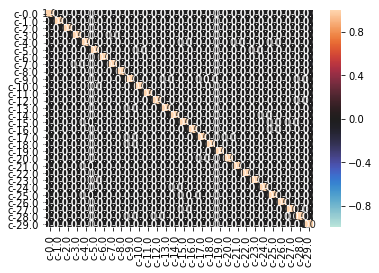

In [43]:
# https://blog.amedama.jp/entry/2017/04/18/230431
import matplotlib.pyplot as plt

corr_mat = clusters.corr(method='pearson')
corr_mat

import seaborn as sons
sons.heatmap(corr_mat,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            annot=True, # True:格子の中に値を表示
            fmt='.1f',
            xticklabels=corr_mat.columns.values,
            yticklabels=corr_mat.columns.values
           )
plt.show()

 - なさそう！

### 最小最大標準化を行う、列単位でMinMaxScaler を活用

In [44]:
log_cluster_onehotencoding3.iloc[:,-30:]

,c-0.0,c-1.0,c-2.0,c-3.0,c-4.0,c-5.0,c-6.0,c-7.0,c-8.0,c-9.0,...,c-20.0,c-21.0,c-22.0,c-23.0,c-24.0,c-25.0,c-26.0,c-27.0,c-28.0,c-29.0
session_id,,,,,,,,,,,,,,,,,,,,,
000048a8-4971-4838-b7d1-c464ae74cb42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0001a0ae-7786-495e-be2a-d2a3a24e0a1a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0001a721-7923-411a-9209-b19f96611d8f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00022350-3008-42ad-bf35-b48b7a5be56a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0002e934-0968-4999-ac97-4dec3b327f8b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00039b3f-a3bf-49c8-b59f-daa2d14622da,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0003afbd-9b54-4625-9fd3-569b0e9f3ec8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000507a7-e470-4835-9b43-1c0b7009bce4,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00051920-9a1a-4ebb-9588-a476e4ec04b8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
### 標準化を行う、列単位でMinMaxScaler を活用
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

data = log_cluster_onehotencoding3.iloc[:,-30:].as_matrix()

scaler = MinMaxScaler()
minmax_culster_log = scaler.fit_transform(data)

# print(scaler.fit(data))
# print(scaler.data_max_)
# print(scaler.transform(data))
# print(scaler.transform([[2, 2]]))
# MinMaxScaler(copy=True, feature_range=(0, 1))


#1ちゃんと最大値が1になっているか確認
b = pd.DataFrame(minmax_culster_log)
b.describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,79384.000000,79384.000000,79384.000000,79384.000000,79384.000000,79384.000000,79384.000000,79384.000000,79384.000000,79384.000000,...,79384.000000,79384.000000,79384.000000,79384.000000,79384.000000,79384.000000,79384.000000,79384.000000,79384.000000,79384.000000
mean,0.003241,0.000692,0.001518,0.000604,0.001045,0.002110,0.001468,0.003583,0.000629,0.000702,...,0.001630,0.000724,0.000727,0.000493,0.001671,0.002117,0.000716,0.000482,0.000912,0.003909
std,0.025205,0.012092,0.016020,0.011371,0.014618,0.020333,0.015492,0.014684,0.012968,0.014871,...,0.017823,0.009340,0.010813,0.013851,0.016850,0.022382,0.010878,0.013233,0.014692,0.021524
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [46]:
b

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.000000,0.0,0.0000,0.0000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
1,0.000000,0.0,0.0000,0.0000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
2,0.000000,0.0,0.0000,0.0000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
3,0.000000,0.0,0.0000,0.0000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,0.000000,0.0,0.0000,0.0000,0.0,0.000000,0.0,0.000000,0.083333,0.0,...,0.0,0.041667,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
5,0.000000,0.0,0.0000,0.0000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
6,0.000000,0.0,0.0000,0.0000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
7,0.000000,0.0,0.0000,0.1250,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
8,0.000000,0.0,0.0000,0.0000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
9,0.000000,0.0,0.0000,0.0000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000


In [47]:
# cv_idが1以上ならCV、そうじゃなければ0
log_cluster_onehotencoding3['cv_flag'] = np.where(log_cluster_onehotencoding3['cv_id_int']>=1,1,0)

In [48]:
cv_flag = log_cluster_onehotencoding3[['cv_flag']]
cv_flag2 = cv_flag.reset_index(drop= True)

In [49]:
cluster_data = pd.concat([cv_flag2,b], axis=1)
cluster_data

,cv_flag,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
0,0,0.000000,0.0,0.0000,0.0000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
1,0,0.000000,0.0,0.0000,0.0000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
2,0,0.000000,0.0,0.0000,0.0000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
3,0,0.000000,0.0,0.0000,0.0000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,0,0.000000,0.0,0.0000,0.0000,0.0,0.000000,0.0,0.000000,0.083333,...,0.0,0.041667,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
5,0,0.000000,0.0,0.0000,0.0000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
6,0,0.000000,0.0,0.0000,0.0000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
7,0,0.000000,0.0,0.0000,0.1250,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
8,0,0.000000,0.0,0.0000,0.0000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
9,0,0.000000,0.0,0.0000,0.0000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000


## クラスター分けのロジスティック回帰(～最小最大標準ver～)

In [50]:
from sklearn import linear_model
clf = linear_model.LinearRegression()

tempder = log_cluster_onehotencoding2.iloc[:,11:-1]
X = topic_data.iloc[:,1:].as_matrix()
y = topic_data.iloc[:,0].as_matrix()

NameError: name 'topic_data' is not defined

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# C=0.01, 0.1, 1, 10, 100 で試した
lr = LogisticRegression(C=10, random_state=0)
scores = cross_val_score(lr, X, y, cv=5)

print("正答率", np.mean(scores), "標準偏差 +/-", np.std(scores))

In [ ]:
id = log_cluster_onehotencoding2.iloc[:,1:]
id

In [ ]:
cluster_data.describe()

In [ ]:
log_cluster_onehotencoding3 = log_cluster_onehotencoding3.fillna(0)

from sklearn import linear_model
clf = linear_model.LinearRegression()

id = cluster_data.iloc[:,1:]
X = cluster_data.iloc[:,1:].as_matrix()
y = cluster_data.iloc[:,0].as_matrix()

clf.C = 1

clf.fit(X,y)

print(pd.DataFrame({"Name":id.columns,
                    "Coefficients":clf.coef_}).sort_values(by='Coefficients') )
print(clf.intercept_)

In [51]:
# clusterが多いものにPVが偏っていることが分かる
log_cluster.cluster.value_counts()

7.0     51685
29.0    15176
19.0    13883
0.0      9414
12.0     8327
2.0      8140
13.0     7255
6.0      7077
11.0     6393
20.0     6103
24.0     5724
16.0     5715
25.0     5068
21.0     4540
5.0      4096
15.0     3531
26.0     3253
10.0     2876
4.0      2822
22.0     2771
28.0     2269
9.0      2061
1.0      2027
18.0     2009
3.0      1956
8.0      1855
17.0     1771
14.0     1740
27.0      875
23.0      719
Name: cluster, dtype: int64

# トピックモデルのアクセスログ分析

In [52]:
topic = pd.read_csv('topic_30.csv', engine='python')

In [53]:
# 0.3をしきい値として、01に割り振る
for topic_num in topic.columns.values[4:]:
    topic[topic_num] = (topic[topic_num] >= 0.3).astype(int)

In [54]:
topic

,Unnamed: 0,Unnamed: 0.1,id,wakachi_deletestopword,topic0,topic1,topic2,topic3,topic4,topic5,...,topic20,topic21,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29
0,0,0,5065,ニート 現在 無職 意思 希薄 15 34歳 人物 ニート 割合 社会 経済 デメリット 要...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,1,923,退職 理由 前 職 退職 理由 人 さまざま 理由 転職理由 退職 理由 上 転職 将来 仕...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,914,ハローワーク 正式名称 公共職業安定所 職業 紹介 失業保険 受給 手続き 失業保険 受給 ...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,3,5075,転職 動機 十人十色 転職 動機 志望動機 ポジティブ 必要 率直 志望動機 あなた 評価 ...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,5125,仕事 納期 あと 仕事 クライアント 迷惑 可能性 判断 時点 納期 前 早め 報告 相談 ...,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,5,5,5090,内閣府 子ども 若者 状況 育成支援 施策 実施 状況 報告 子ども 若者 白書 平成30年...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,6,6,5166,有給 買い上げ 法律的 原則 例外 会社 就業規則 ケース 退職 日 計画 有給休暇 使用 ...,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
7,7,7,5168,中途 面接 強み 仕事 価値観 職歴 キャリアプラン 質問 入念 自己 分析 企業研究 入社...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,8,8,5066,職歴 コミュニケーション 苦手 理由 ニート 採用 企業 中 ニート 脱却 成功 鍵 生活リ...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,9,9,2904,新卒 年度 卒業 見込み 学生 年齢 上限 近年 国 卒業後 3年 新卒 扱い 指針 既卒 ...,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
del topic['Unnamed: 0.1']
del topic['Unnamed: 0']

In [56]:
# アクセスログとクラスターを結合させる
log_topic = pd.merge(topic, test_df, left_on='id', right_on='landing_useful_num_int', how='right')

In [57]:
log_topic.cv_id_int.value_counts()

0    196669
1      4010
Name: cv_id_int, dtype: int64

In [58]:
log_topic2 = log_topic.rename(columns={'topic':'landing_topic'})
log_topic2

# # del log_topic2['Unnamed: 0']
# del log_topic2['text1']
# del log_topic2['wakachi']
# del log_topic2['session_start_time']
# del log_topic2['session_end_time']
# del log_topic2['path_length']
# del log_topic2['useful_num']
# del log_topic2['landing_useful_num']
# del log_topic2['id']
# del log_topic2['ht_cv_flg']
# del log_topic2['landing_user_agent']
# del log_topic2['landing_referrer']
# del log_topic2['cv_id']
# del log_topic2['node_list']
# del log_topic2['landing_ip']
# del log_topic2['landing_browser']
# del log_topic2['landing_os']


# lnode_list_remove_duplicatedから数字を抜き取る
log_topic2['useful_id'] = log_topic2.node_list_remove_duplicated.str.extract('(/useful/[0-9]+)')
log_topic2['useful_id2'] = log_topic2.useful_id.str.extract('([0-9]+)')
# del log_topic2['useful_id']


log_topic3 = log_topic2.fillna(0)
log_topic4 = log_topic3.assign(useful_id2_int = log_topic3['useful_id2'].astype(int))
# del log_topic4['useful_id2']
log_topic4

# アクセスログとクラスターを結合させる
log_topic_all = pd.merge(topic, log_topic4, left_on='id', right_on='useful_id2_int', how='right')
log_topic_all

# del log_topic_all['Unnamed: 0']
# del log_topic_all['id']
# del log_topic_all['text1']
# del log_topic_all['wakachi']
log_topic_all2 = log_topic_all.rename(columns={'topic':'pv_page_topic'})


C:\Users\arisa.kamoshita\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
C:\Users\arisa.kamoshita\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


In [59]:
log_topic_onehotencoding3 = log_topic_all2.fillna(0)

In [60]:
log_topic_onehotencoding3.iloc[:,2:32]

,topic0_x,topic1_x,topic2_x,topic3_x,topic4_x,topic5_x,topic6_x,topic7_x,topic8_x,topic9_x,...,topic20_x,topic21_x,topic22_x,topic23_x,topic24_x,topic25_x,topic26_x,topic27_x,topic28_x,topic29_x
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
### 標準化を行う、列単位でMinMaxScaler を活用
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

data = log_topic_onehotencoding3.iloc[:,2:32].as_matrix()


scaler = MinMaxScaler()
minmax_topic_log = scaler.fit_transform(data)

# print(scaler.fit(data))
# print(scaler.data_max_)
# print(scaler.transform(data))
# print(scaler.transform([[2, 2]]))
# MinMaxScaler(copy=True, feature_range=(0, 1))


#1ちゃんと最大値が1になっているか確認
a = pd.DataFrame(minmax_topic_log)
a

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
log_topic_onehotencoding4 = log_topic_onehotencoding3.reset_index(drop = True)
log_topic_onehotencoding5 = log_topic_onehotencoding4[['cv_id_int']]

In [63]:
log_topic_onehotencodingp6 = pd.concat([a,log_topic_onehotencoding5],axis = 1)

In [64]:
log_topic_onehotencodingp6.describe()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,cv_id_int
count,200679.000000,200679.000000,200679.000000,200679.000000,200679.000000,200679.000000,200679.000000,200679.000000,200679.000000,200679.000000,...,200679.000000,200679.000000,200679.000000,200679.000000,200679.000000,200679.000000,200679.000000,200679.000000,200679.000000,200679.000000
mean,0.016100,0.023625,0.022239,0.096702,0.017182,0.046901,0.033461,0.001988,0.055183,0.023146,...,0.041674,0.027337,0.004973,0.012682,0.010170,0.027327,0.007011,0.050568,0.031378,0.019982
std,0.125862,0.151878,0.147462,0.295552,0.129948,0.211427,0.179839,0.044546,0.228337,0.150369,...,0.199843,0.163064,0.070345,0.111898,0.100335,0.163036,0.083439,0.219115,0.174339,0.139939
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [65]:
import scipy as sp
X = log_topic_onehotencodingp6.iloc[:,:30]
X -= sp.mean(X,axis = 0)
X /= sp.std(X, ddof = 1, axis = 0)
sp.mean(X,axis=0).head(10).round(3)
sp.std(X, ddof=1, axis = 0).head(10)

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
dtype: float64

In [66]:
X = log_topic_onehotencodingp6.iloc[:,:30].as_matrix()
y = log_topic_onehotencodingp6.iloc[:,-1].as_matrix()
log_topic_onehotencodingp6.iloc[:,-1]

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
         ..
200649    0
200650    0
200651    0
200652    0
200653    0
200654    0
200655    0
200656    1
200657    0
200658    0
200659    0
200660    0
200661    0
200662    0
200663    0
200664    0
200665    0
200666    0
200667    0
200668    0
200669    0
200670    0
200671    0
200672    0
200673    0
200674    0
200675    0
200676    0
200677    0
200678    0
Name: cv_id_int, Length: 200679, dtype: int32

In [67]:
log_topic_onehotencodingp6

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,cv_id_int
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [68]:
log_topic_onehotencodingp6.describe()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,cv_id_int
count,200679.000000,200679.000000,200679.000000,200679.000000,200679.000000,200679.000000,200679.000000,200679.000000,200679.000000,200679.000000,...,200679.000000,200679.000000,200679.000000,200679.000000,200679.000000,200679.000000,200679.000000,200679.000000,200679.000000,200679.000000
mean,0.016100,0.023625,0.022239,0.096702,0.017182,0.046901,0.033461,0.001988,0.055183,0.023146,...,0.041674,0.027337,0.004973,0.012682,0.010170,0.027327,0.007011,0.050568,0.031378,0.019982
std,0.125862,0.151878,0.147462,0.295552,0.129948,0.211427,0.179839,0.044546,0.228337,0.150369,...,0.199843,0.163064,0.070345,0.111898,0.100335,0.163036,0.083439,0.219115,0.174339,0.139939
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## ロジスティック回帰

In [69]:
from sklearn import linear_model
clf = linear_model.LinearRegression()

# tempder = log_topic_onehotencoding6.iloc[:,11:-1]
X = log_topic_onehotencodingp6.iloc[:,:30].as_matrix()
y = log_topic_onehotencodingp6.iloc[:,-1].as_matrix()



from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# C=0.01, 0.1, 1, 10, 100 で試した
lr = LogisticRegression(C=10, random_state=0)
scores = cross_val_score(lr, X, y, cv=5)

print("正答率", np.mean(scores), "標準偏差 +/-", np.std(scores))


log_topic_onehotencodingp6 = log_topic_onehotencodingp6.fillna(0)

from sklearn import linear_model
clf = linear_model.LinearRegression()

id = log_topic_onehotencodingp6.iloc[:,:30]
X = log_topic_onehotencodingp6.iloc[:,:30].as_matrix()
y = log_topic_onehotencodingp6.iloc[:,-1].as_matrix()

clf.C = 1

clf.fit(X,y)

print(pd.DataFrame({"Name":id.columns,
                    "Coefficients":clf.coef_}).sort_values(by='Coefficients') )
print(clf.intercept_)


正答率 0.980017839433 標準偏差 +/- 1.99148483793e-07
    Coefficients Name
10     -0.034631   10
27     -0.032479   27
18     -0.032081   18
2      -0.031157    2
21     -0.029327   21
26     -0.028144   26
0      -0.027608    0
7      -0.027577    7
28     -0.027361   28
23     -0.026731   23
4      -0.026403    4
9      -0.025493    9
5      -0.025343    5
1      -0.025124    1
12     -0.024988   12
19     -0.024979   19
16     -0.024824   16
15     -0.023827   15
25     -0.023311   25
20     -0.021900   20
22     -0.021327   22
6      -0.021068    6
14     -0.021048   14
24     -0.019582   24
17     -0.018870   17
3      -0.018164    3
29     -0.017148   29
13     -0.016878   13
8      -0.015486    8
11     -0.013402   11
0.0410932920435


# 課題
 - トピックモデルが全てマイナスになってしまったのはなぜか
 - 他にもクラスター×クラスターで分類ができないか
 - クラスターごとに係数がでたが、どれほど信じられるのか